In [1]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import torch
import math
import timm

import transforms.eft as Eft
from datasets.transformed_dataset import TransformedDataset
from utils import plot_confusion_matrix
from models.radio_rec_model import RadioRecNetwork
from models.resnet import create_resnet_2d
import datasets.signal_file_dataset as sfds
import os.path

In [2]:
import pytorch_lightning as pl
pl.__version__

'2.0.9'

In [3]:
torch.__version__

'2.0.1+cu118'

In [4]:
print(torch.cuda.is_available())

True


In [5]:
data_root_dir = "d:/data/duijiangji"
checkpoint_dir=f'./exp/radiorec/duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints'

In [6]:
train_dir = os.path.join(data_root_dir, 'train')
train_file_set = sfds.SignalFileSet(train_dir, 'bin')
train_file_set.print_info()

test_dir = os.path.join(data_root_dir, 'test')
test_file_set = sfds.SignalFileSet(test_dir, 'bin')
test_file_set.print_info()

data path: d:/data/duijiangji\train
classes: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
{'A': 24, 'B': 24, 'C': 23}
data path: d:/data/duijiangji\test
classes: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
{'A': 10, 'B': 10, 'C': 10}


In [7]:
import datasets.signal_file_dataset as sfds
sig_file_conf = sfds.SignalFileConfig()
sig_file_conf.fs = 256000      # 256K Hz sample rate
sig_file_conf.seg_len = 100   # 100ms ???
sig_file_conf.seg_shift = 100 # 100 ms, no overlap
sig_file_conf.max_num = 6000
sig_file_conf.is_complex = True
sig_file_conf.energy_threshold = 1.0


train_dataset = sfds.SignalDataSet(train_file_set, sig_file_conf)
train_dataset.print_info()

test_dataset = sfds.SignalDataSet(test_file_set, sig_file_conf)
test_dataset.print_info()

class list: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
seg count for each class: {'A': 11621, 'B': 11042, 'C': 11394}
class list: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
seg count for each class: {'A': 4627, 'B': 4790, 'C': 4909}


In [8]:
train_dataset.save(os.path.join(data_root_dir, 'train-100ms.hdf5'))
test_dataset.save(os.path.join(data_root_dir, 'test-100ms.hdf5'))

In [9]:
train_dataset = sfds.SignalDataSet()
train_dataset.load(os.path.join(data_root_dir, 'train-100ms.hdf5'))
train_dataset.print_info()

test_dataset = sfds.SignalDataSet()
test_dataset.load(os.path.join(data_root_dir, 'test-100ms.hdf5'))
test_dataset.print_info()

class list: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
seg count for each class: {'A': 11621, 'B': 11042, 'C': 11394}
class list: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
seg count for each class: {'A': 4627, 'B': 4790, 'C': 4909}


In [10]:
train_dataset.data.shape

(34057, 25600, 2)

In [11]:
train_dataset.labels.shape

(34057,)

In [12]:
class_list = train_dataset.class_list
num_classes = len(class_list)

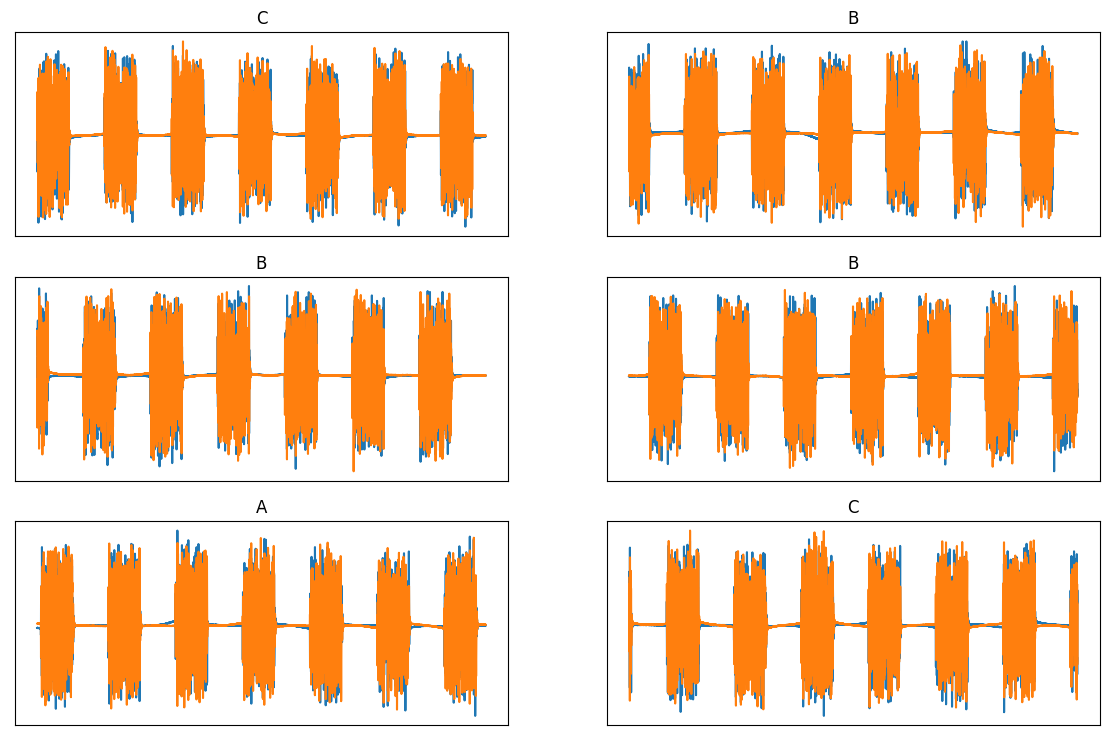

In [13]:
# Repeat but plot andom sampling of the data
from datasets.visualize import IQVisualizer

example_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=6,
    num_workers=0,
    shuffle=True,
    drop_last=True,
)
visualizer = IQVisualizer(
    data_loader = example_dataloader,
    visualize_target_transform = lambda target: [class_list[int(index)] for index in target]
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

In [14]:
from transforms.transforms import Compose
from transforms.spectrogram_transform import SpectrogramConfig, Spectrogram
from transforms.impairment import Normalize, AddNoise, SpectrogramPatchShuffle, RandomPhaseShift

interleave_to_complex = Eft.InterleaveComplex()

random_phase_shift = RandomPhaseShift(phase_offset=(-1, 1))

add_noise = AddNoise((-40, -20)) # Added AWGN power range is (-40, -20) dB

normalize_transform = Normalize(norm=2)

spectrogram_config = SpectrogramConfig()
spectrogram_config.nperseg = 256
spectrogram_config.noverlap = 128
spectrogram_config.nfft = 256
spectrogram_config.window = 'hann'
spectrogram_config.return_onesided = False
spectrogram_config.mode = 'magnitude'
spectorgram_transform = Spectrogram(spectrogram_config)

spec_patch_shuffle = SpectrogramPatchShuffle(patch_size=(2,8), shuffle_ratio=(0.01,0.10))

train_transform = Compose([interleave_to_complex, random_phase_shift, add_noise, normalize_transform, 
                           spectorgram_transform, spec_patch_shuffle])
train_dataset = TransformedDataset(train_dataset, transform = train_transform)

test_transform = Compose([interleave_to_complex, normalize_transform, spectorgram_transform])
test_dataset = TransformedDataset(test_dataset, transform = test_transform)

# interleave_to_2d = Eft.InterleaveTo2D()
# train_dataset = TransformedDataset(train_dataset, transform = interleave_to_2d)
# test_dataset = TransformedDataset(test_dataset, transform = interleave_to_2d)

In [15]:
num = len(test_dataset)
num_test = math.floor(0.5 * num)
num_val = num - num_test

test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [num_test, num_val],
                                                                         generator = torch.Generator().manual_seed(42))
idx = np.random.randint(len(test_dataset))
data, label = test_dataset[idx]
channels = data.shape[0]
print("Train dataset length: {}".format(len(train_dataset)))
print("Val dataset length: {}".format(len(val_dataset)))
print("Test dataset length: {}".format(len(test_dataset)))

print("Data shape: {}".format(data.shape))
print(f"Channels: {channels}")
print("Label Index: {}".format(label))
print("Label Class: {}".format(class_list[label]))

Train dataset length: 34057
Val dataset length: 7163
Test dataset length: 7163
Data shape: (1, 256, 199)
Channels: 1
Label Index: 2
Label Class: C


In [16]:
# ----
# ### Format Dataset for Training
# Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=False,
    drop_last=True,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=False,
    drop_last=False,
)

In [17]:
model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
# model = create_resnet(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
# Training Config
learning_rate=0.002
epochs = 30

radiorec_model = RadioRecNetwork(model, learning_rate = learning_rate)

In [20]:
# ----
# ### Train the Model
# To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.
import os

if not os.path.exists(checkpoint_dir):
    print(f'mkdir: {checkpoint_dir}')
    os.makedirs(checkpoint_dir)

In [21]:
# Setup checkpoint callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename='{epoch}-{val_loss:.2f}',
    save_top_k=3,
    save_last=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

In [22]:
# Create and fit trainer
trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, devices=1, accelerator="gpu"
)

trainer.fit(radiorec_model, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory D:\radiorec\exp\radiorec\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mdl  | ResNet | 11.2 M
--------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.687    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

D:\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 532: 'val_loss' reached 11.42474 (best 11.42474), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=0-val_loss=11.42.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1064: 'val_loss' reached 0.18170 (best 0.18170), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=1-val_loss=0.18.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 1596: 'val_loss' reached 1.20915 (best 0.18170), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=2-val_loss=1.21.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 2128: 'val_loss' reached 0.21613 (best 0.18170), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=3-val_loss=0.22.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 2660: 'val_loss' reached 0.18410 (best 0.18170), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=4-val_loss=0.18.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 3192: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 3724: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 4256: 'val_loss' reached 0.11293 (best 0.11293), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=7-val_loss=0.11.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 4788: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 5320: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 5852: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 6384: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 6916: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 7448: 'val_loss' reached 0.03108 (best 0.03108), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=13-val_loss=0.03.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 7980: 'val_loss' reached 0.07677 (best 0.03108), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=14-val_loss=0.08.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 8512: 'val_loss' reached 0.05934 (best 0.03108), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=15-val_loss=0.06.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 9044: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 9576: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 10108: 'val_loss' reached 0.05899 (best 0.03108), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=18-val_loss=0.06.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 10640: 'val_loss' reached 0.00436 (best 0.00436), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=19-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 11172: 'val_loss' reached 0.03644 (best 0.00436), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=20-val_loss=0.04.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 11704: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 12236: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 12768: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 13300: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 13832: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 14364: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 14896: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 15428: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 15960: 'val_loss' was not in top 3
`Trainer.fit` stopped: `max_epochs=30` reached.


In [23]:
checkpoint_callback.best_model_path

'D:\\radiorec\\exp\\radiorec\\duijiangji-spectrogram-phaseshift-addnoise-norm-spec-shuffle-100ms-checkpoints\\epoch=19-val_loss=0.00.ckpt'

In [24]:
# After the model is trained, the checkpoint's weights are loaded into the model and the model is put into evaluation mode. The validation set is looped through, inferring results for each example and saving the predictions and the labels. Finally, the labels and predictions are passed into our confusion matrix plotting function to view the results and also passed into the `sklearn.metrics.classification_report` method to print metrics of interest.
checkpoint_filename = checkpoint_callback.best_model_path

# Load best checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(
    checkpoint_filename, map_location=lambda storage, loc: storage
)

model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
# model = create_resnet(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
test_model = RadioRecNetwork(model, learning_rate = learning_rate)
test_model.load_state_dict(checkpoint["state_dict"])
test_model = test_model.to(device=device).eval()

In [25]:
# ### Evaluate the val set

# Infer results over validation set
num_val_examples = len(val_dataset)
y_raw_preds = np.empty((num_val_examples, num_classes))
y_preds = np.zeros((num_val_examples,))
y_true = np.zeros((num_val_examples,))

for i in tqdm(range(0, num_val_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = val_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

100%|█████████████████████████████████████████████████████████████████████████████| 7163/7163 [00:46<00:00, 152.44it/s]


Val set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2323
         1.0       1.00      1.00      1.00      2407
         2.0       1.00      1.00      1.00      2433

    accuracy                           1.00      7163
   macro avg       1.00      1.00      1.00      7163
weighted avg       1.00      1.00      1.00      7163



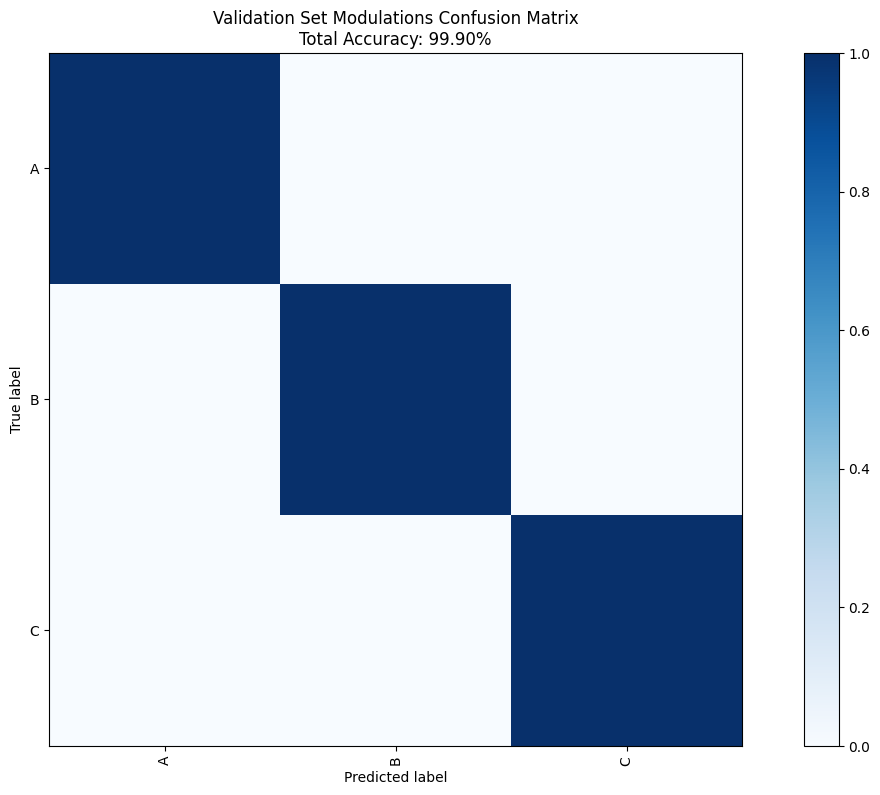

In [26]:
acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Validation Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/val_result.png")

print("Val set classification report:")
print(classification_report(y_true, y_preds))

100%|█████████████████████████████████████████████████████████████████████████████| 7163/7163 [00:50<00:00, 142.30it/s]


Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2304
         1.0       1.00      1.00      1.00      2383
         2.0       1.00      1.00      1.00      2476

    accuracy                           1.00      7163
   macro avg       1.00      1.00      1.00      7163
weighted avg       1.00      1.00      1.00      7163



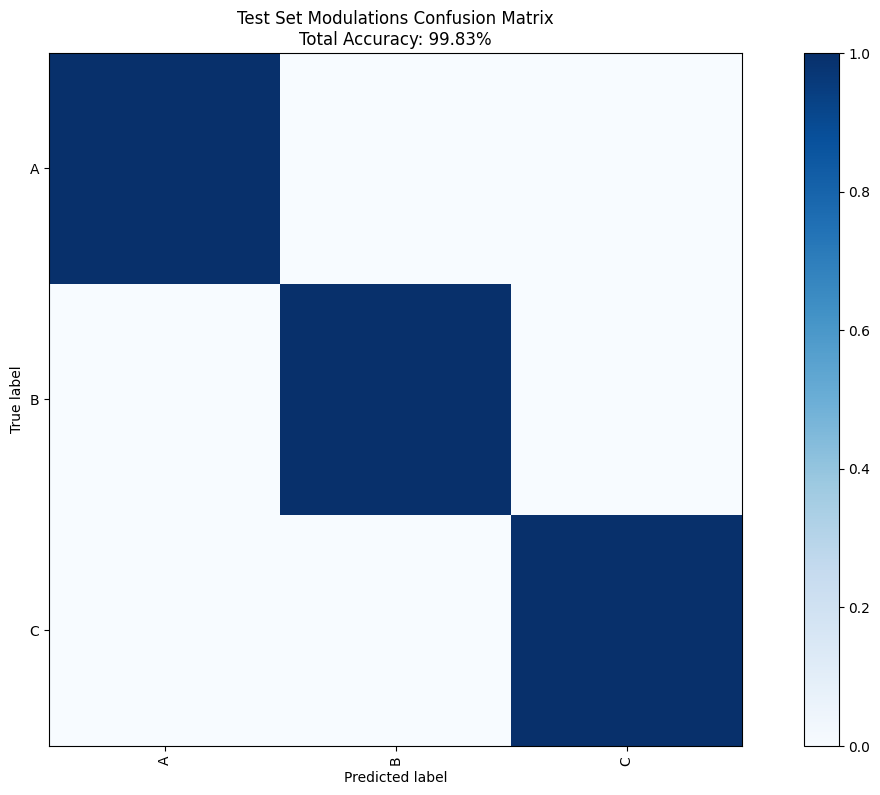

In [27]:
# ----
# ### Evaluate the test set

# Infer results over validation set
num_test_examples = len(test_dataset)
y_raw_preds = np.empty((num_test_examples, num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = test_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Test Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/test_result.png")

print("Test set classification report:")
print(classification_report(y_true, y_preds))